# Data Preparation

The first step in this project is actually getting the raw stock data from Alpha Vantage and processing into a form ready for training.

Before starting this process you must get an API key from this [site](https://www.alphavantage.co/support/#api-key).

## 1. Load some necessary modules

In [2]:
# You only need to run this once on a SageMaker instance or on your PC
# If you haven't run it yet, please uncomment and run.
# !pip install alpha_vantage

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_datareader import data
import seaborn as sns
import time
import yaml

from alpha_vantage.timeseries import TimeSeries

%matplotlib inline

## 2. Read the user defined settings

In [15]:
with open('settings.yml') as f:
    settings = yaml.safe_load(f)

## 3. Download the stock history
Note you have to manually enter your Alpha Vantage API key in the following cell.  It is unique to each user and is limited to 5 API requests per minute and 500 requests per day, so please don't use someone else's key.

In [16]:
# Set your API key
api_key = 'AIM9J0PA8YV2A12F'

# Format connection
ts = TimeSeries(key=api_key, output_format='pandas')

# Read saved data if it exists
if os.path.isfile('stock-data.pkl'):
    saved_stocks = pd.read_pickle('stock-data.pkl')
    saved_stock_names = saved_stocks.columns.to_list()
else:
    saved_stock_names = []
    
# To avoid hitting the 5 requests per minute, we only pull 1 per 12 sec
times = []
stocks = []
failed = []
for ticker in settings['tickers']:
    if ticker in saved_stock_names:
        stocks.append(saved_stocks.loc[:, [ticker]])
    else:
        if len(times) >= 5:
            delta = 61 - (time.time() - times[-5])
            if delta > 0:
                print("Taking a {:.0f}s break to avoid 5 req/min limit.".format(delta))
                time.sleep(delta)
        
        print("Reading {} from API.".format(ticker))
        try:
            data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
            data = data.rename(columns={'5. adjusted close': ticker})
            stocks.append(data.loc[settings['data_end']:settings['data_start'], [ticker]])
        except:
            print("\tFailed to pull {} from API.".format(ticker))
            failed.append(ticker)
        times.append(time.time())
stocks = pd.concat(stocks, axis=1)
stocks.to_pickle('stock-data.pkl')
if len(failed) > 0:
    print("Failed to get following tickers from API:")
    print(failed)


Reading RCI-B.TO from API.
Reading SJR-B.TO from API.
Reading CJR-B.TO from API.
Reading ATD-B.TO from API.
Reading BBD-B.TO from API.
Taking a 51s break to avoid 5 req/min limit.
Reading TECK-B.TO from API.
Reading CUF-UN.TO from API.
Reading CAR-U.TO from API.
	Failed to pull CAR-U.TO from API.
Reading GIB-A.TO from API.
Reading CAD=X from API.
	Failed to pull CAD=X from API.
Failed to get following tickers from API:
['CAR-U.TO', 'CAD=X']


Plot the data to visually check for bad data.  You may want to manually play with the plotting to find data of interest.

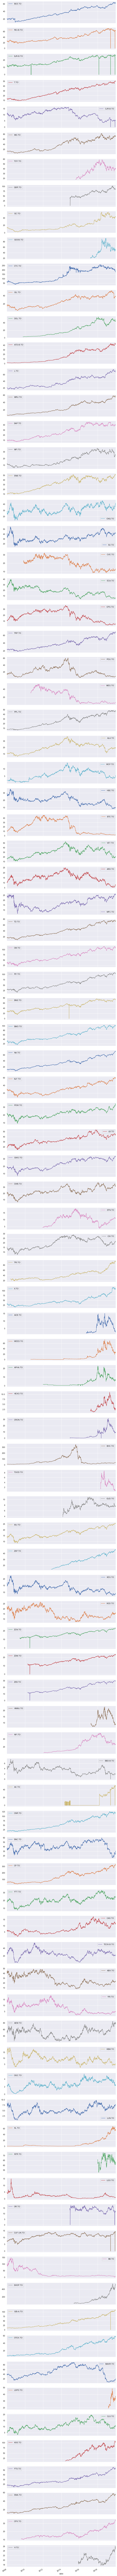

In [17]:
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

First thing to notice is not all stocks have data for the full date range.  Since we need a full dataset to train, we will delete these stocks.

In [49]:
# Here are the stocks with NAN values.  Make sure this matches the plots above.
print(stocks.columns[stocks.isna().any()])
print("\nThere are {} stocks that lack data.".format(sum(stocks.isna().any())))

Index(['TOY.TO', 'QSR.TO', 'GOOS.TO', 'DOL.TO', 'CVE.TO', 'MEG.TO', 'EFN.TO',
       'TRI.TO', 'ACB.TO', 'WEED.TO', 'APHA.TO', 'HEXO.TO', 'CRON.TO',
       'TGOD.TO', 'GUD.TO', 'ZSP.TO', 'ZCN.TO', 'ZDM.TO', 'ZEB.TO', 'HMMJ.TO',
       'NFI.TO', 'AC.TO', 'NTR.TO', 'OR.TO', 'SHOP.TO', 'LSPD.TO', 'KXS.TO',
       'CPX.TO', 'H.TO'],
      dtype='object')

There are 29 stocks that lack data.


In [52]:
# Now we delete the imcomplete stocks
stocks = stocks.loc[:, ~stocks.isna().any()]
new_data.shape

(3012, 69)

If you see any data with drop outs, you may wish to reload to see if the source is defective or if there was an issue in the download.  In the cell below I'm refreshing the 'RCI-B.TO' stock to see if the data is bad.

In [38]:
ticker = 'RCI-B.TO'
data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
data = data.rename(columns={'5. adjusted close': ticker})

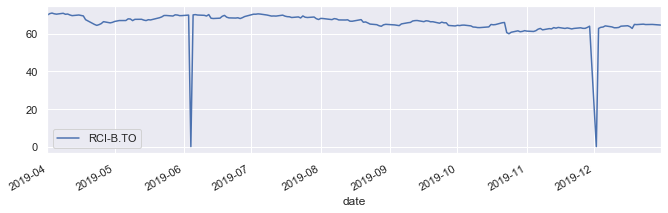

In [39]:
axes = data.loc['2019':'2019-04', [ticker]].plot(figsize=(11, 3))
plt.show()

Looks like the data is bad at the source so I am going to 'fill' the missing data with a linear interpolation.

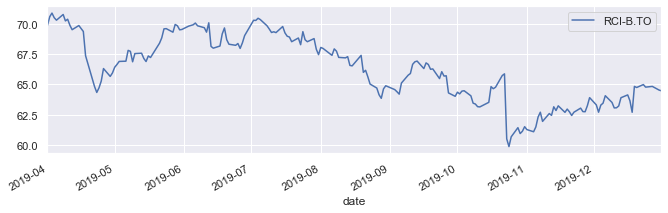

In [40]:
data = data.replace(0, np.nan).interpolate()
axes = data.loc['2019':'2019-04', [ticker]].plot(figsize=(11, 3))
plt.show()

That cleaned it up.  Now I'm going to do the same for all data sets.

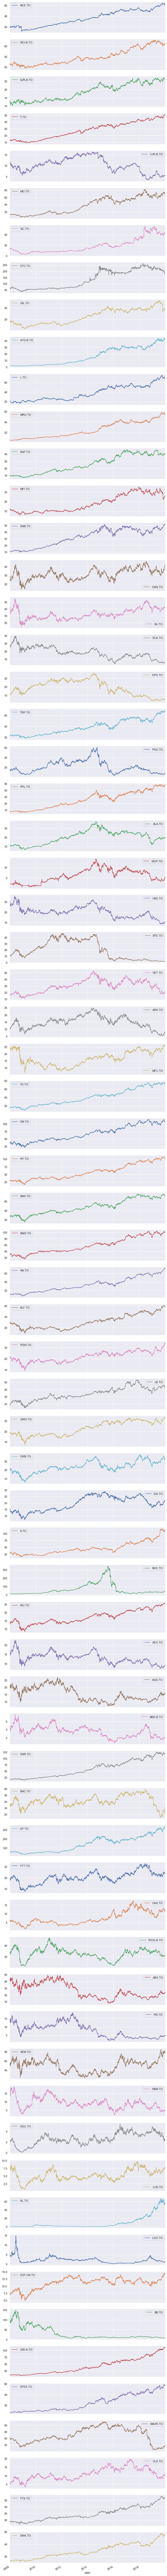

In [53]:
stocks = stocks.replace(0, np.nan).interpolate()
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

**Now that's a pretty dataset!!!**

In [57]:
print(stocks.columns)
print(stocks.shape)
stocks.to_pickle('stock-data-cleaned.pkl')

Index(['BCE.TO', 'RCI-B.TO', 'SJR-B.TO', 'T.TO', 'CJR-B.TO', 'MG.TO', 'GC.TO',
       'CTC.TO', 'GIL.TO', 'ATD-B.TO', 'L.TO', 'MRU.TO', 'SAP.TO', 'MFI.TO',
       'ENB.TO', 'CNQ.TO', 'SU.TO', 'ECA.TO', 'CPG.TO', 'TRP.TO', 'POU.TO',
       'PPL.TO', 'ALA.TO', 'WCP.TO', 'HSE.TO', 'BTE.TO', 'VET.TO', 'ARX.TO',
       'MFC.TO', 'TD.TO', 'CM.TO', 'RY.TO', 'BNS.TO', 'BMO.TO', 'NA.TO',
       'SLF.TO', 'POW.TO', 'LB.TO', 'GWO.TO', 'CWB.TO', 'CIX.TO', 'X.TO',
       'BHC.TO', 'XIU.TO', 'XEG.TO', 'XGD.TO', 'BBD-B.TO', 'CNR.TO', 'SNC.TO',
       'CP.TO', 'FTT.TO', 'CAS.TO', 'TECK-B.TO', 'ABX.TO', 'YRI.TO', 'AEM.TO',
       'HBM.TO', 'OGC.TO', 'LUN.TO', 'KL.TO', 'LGO.TO', 'CUF-UN.TO', 'BB.TO',
       'GIB-A.TO', 'OTEX.TO', 'MAXR.TO', 'CLS.TO', 'FTS.TO', 'EMA.TO'],
      dtype='object')
(3012, 69)


## 4. Create the true signals that we will try to predict
Note we will reload the data saved in the previous step so you can start here instead of rerunning the above steps.  You may have to reload the module in the second cell.